In [139]:
import pandas as pd
import os
import string
import nltk
from nltk.corpus import stopwords
import re
from spacy import displacy
import regex
import spacy
nlp = spacy.load('en')

In [140]:
from argparse import Namespace

args = Namespace(
    input_path = './input',
    batch_size = 128,
    learning_rate = 0.01,
    n_epochs = 100,
    seed = 43
)

In [141]:
from zipfile import ZipFile

with ZipFile(os.path.join(args.input_path, 'yelp.csv.zip')) as zip:
    with zip.open('yelp.csv') as file:
        data = pd.read_csv(file)
        
data.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [142]:
data = data[['stars', 'text']]
data.head()

,stars,text
0,5,My wife took me here on my birthday for breakf...
1,5,I have no idea why some people give bad review...
2,4,love the gyro plate. Rice is so good and I als...
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!..."
4,5,General Manager Scott Petello is a good egg!!!...


In [143]:
data ['positive'] = data ['stars'] > 3
data ['positive'] = data ['positive'].astype(int)
data.sample(10)

,stars,text,positive
3311,4,Fun Saturday night music venue with good food ...,1
8277,2,I could remember Tokyo Expresses were everywhe...,0
1012,5,Enjoyed the egg rolls. So glad that they were...,1
6471,1,I went today with three friends for dinner aro...,0
6180,1,Not worth comin here. I'm all for food like th...,0
6235,5,"Having spent lots of time in Sonora, Mexico ov...",1
9963,4,"The drinks here are great, and the baked goods...",1
8274,4,This place really hits the spot. It's everyth...,1
1469,3,Someone already commented on the large Cow mur...,0
9387,5,By far the best taco shop in the valley. Their...,1


C:\Users\vas\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\vas\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


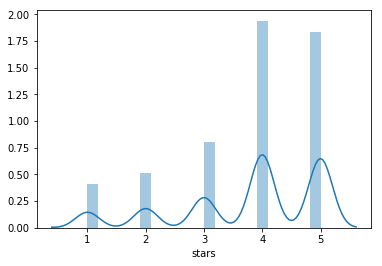

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

raw_data = data

sns.distplot(data['stars'])

In [145]:
y = data ['positive']
data = data ['text']

In [146]:
data.values.ravel()

array(['My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.\n\nDo yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I\'ve ever had.  I\'m pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.\n\nWhile EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I\'ve ever had.\n\nAnyway, I can\'t wait to go back!',
       'I have no idea why some people give bad reviews about this place. It goes to show 

In [147]:
spacy.explain('PART')

'particle'

In [226]:
#y = data['positive']
#data.drop(['stars', 'positive'], axis=1, inplace=True)

from spacy import displacy
nlp = spacy.load('en')
translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
#stops = set(stopwords.words('english'))
bad_pos = set(['PROPN','DET','NOUN','SYM','PUNCT','NUM','PART','X'])

def preprocess(x):
    x = x.lower()
    regex = re.compile("n't")
    x = regex.sub(' not', x)
    #x = x.replace('n\'t', ' not')
    x = x.translate(translator)
    regex = re.compile(r'[\+\d]')
    x = regex.sub(' ', x)
    doc = nlp(x)    
    x = [str(word.lemma_).strip() 
         for word in doc if len(str(word).strip()) > 2 and
         word.pos_ not in bad_pos and
         (word.text == 'not' or str(word) not in stops)]
    #for word in doc:
    #    print('{} --> shape {}, tag {}, pos {}, dep {}'.format(word.text, word.shape_, word.tag_, word.pos_, word.dep_))
    x = ' '.join(x)
    return x

text = "Vahid 32 Google w324324f 32  is a she this told her? \t \tnn Ms. Zhila \t the better well quitely good the basket run James \n \r"
#text = "He couldn't be better James"
docx = nlp(text)
displacy.render(docs=docx, style='ent', jupyter=True)

print('After preprocessing:', preprocess(text))
    
# Just for debugging ...
#data = raw_data.copy()
#print(data)

#vectorizer = CountVectorizer(vahid, stop_words=None, ngram_range=(1, 1))


#X_train = X_train.values.ravel()
#X_test = X_test.values.ravel()
#X_train

After preprocessing: tell good well quitely good


In [149]:
%%time
data = data.apply(lambda x: preprocess(x))

Wall time: 4min 55s


In [150]:
data.shape

(10000,)

In [151]:
data = data.values.ravel()

In [152]:
print ('{} --> {}'.format(data[10], y[10]))
print('{} --> {}'.format(data[15], y[15]))

oldish own sweet perhaps sweet lowdown giant super cheap basically endless marvelous --> 1
worth small absolutely not bad maybe die not know want tell really make mad order small could care less take sit look around say large large wow would nice tell leave hungry mad unsatisfied teach upsell tell small affect negatively severely overprice not back unless desperate --> 0


In [153]:
raw_data = data
data

array(['take excellent perfect make sit outside overlook absolute excellent arrive quickly busy look like fill pretty quickly earlier get good get bloody phenomenal simply good ever pretty sure use blend fresh order amazing look excellent white scramble vegetable tasty delicious come griddled amazing absolutely make complete good ever anyway not wait back',
       'give bad go show please probably grip many like arrive past pretty crowded think sunday think would wait forever get say seat come back seat else seat come get pleasant seat good well place decide want share baked small try huge get small personal get small awesome like better like better like box take home great not like bad go show try bad serious',
       'love good also dig', ...,
       'recently visit last visit convince good consistently good great outstanding spend various across always amazed bad popular not first upon walk warm receive cross know make feel special many focus could spend talk sum hate wrap crazy goo

In [242]:
doc = {}
vocab_size = 1
def string_to_ints(x):
    global vocab_size
    words = x.split()
    res = []
    for word in words:
        if word not in doc:
            doc[word] = vocab_size
            vocab_size += 1
        res.append(doc[word])
    return np.array(res)
def lookup_word(word):
    if word in doc:
        return doc [word]
    return 0

In [243]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# Just for debugging ...
data = raw_data.copy()

for i in range(data.shape[0]):
    data[i] = string_to_ints(data [i])
data

array([array([ 1,  2,  3,  4,  5,  6,  7,  8,  2,  9, 10, 11, 12, 13, 14, 15, 10,
       16, 17, 18, 17, 19, 20, 21, 18, 22, 15, 23, 24, 25, 26, 27, 28, 12,
        2, 29, 30, 31, 32, 33, 34, 35, 28, 36,  4, 37, 18, 22, 38, 39, 40,
       41]),
       array([42, 43, 44, 45, 46, 47, 48, 49, 13,  9, 50, 15, 51, 52, 53, 52, 54,
       40, 55, 17, 56, 57, 34, 41, 57, 58, 57, 34, 17, 59, 57, 18, 60, 61,
       62, 63, 64, 65, 66, 67, 68, 17, 66, 69, 17, 66, 70, 13, 71, 13, 71,
       13, 72,  1, 73, 74, 39, 13, 43, 44, 45, 67, 43, 75]),
       array([76, 18, 77, 78]), ...,
       array([  965,  1133,   246,  1133,  1732,    18,   429,    18,    74,
         263,   817,  1048,   808,   104,  2691,    43,  1631,    39,
         274,  1057,   101,   153,   132,  1391,   127,     4,   435,
         423,    49,   973,   288,   817,   584,  1435,   572,   190,
         613,    18,  8879,  1156,    18,   349,   278,     9,   351,
        1117,   780,    18,    39,   236,   164,    39,    12,  3584

In [244]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline


split_sz = 0.8
sz = int(split_sz * data.shape[0])
X_train, y_train = data [0 : sz], y [0 : sz]
X_test, y_test = data [sz :], y [sz :]
data.shape, sz, X_train.shape, X_test.shape

((10000,), 8000, (8000,), (2000,))

In [245]:
from sklearn.utils import shuffle
import torch.nn as nn
import torch.nn.functional as F
import torch

In [246]:
def generate_minibatch (X, y):
    X, y = shuffle(X, y)
    for i in range (0, X.shape [0], args.batch_size):
        X_mini = X [i:i + args.batch_size]
        y_mini = y [i:i + args.batch_size]
        
        
        #X_mini = X_mini.values.reshape(-1, 1)
        y_mini = y_mini.values.reshape(-1, 1)
        
        #print(X_mini.shape)
        #print(y_mini.shape)
        
        X_mini = torch.Tensor(X_mini)
        y_mini = torch.Tensor(y_mini)
        
        yield X_mini, y_mini

In [181]:
class reviewClassifier(nn.Module):
    def __init__(self, in_features):
        super(reviewClassifier, self).__init__()
        embed = nn.Embedding(num_embeddings=vocab_size, num_embeddings=128)
        self.model = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=32),
            nn.ReLU(),
            nn.,
            nn.Sigmoid()
        )
    def forward(self, x):
        y_pred = torch.sigmoid(self.model(x).squeeze())
        return y_pred

In [182]:
import torch.optim as optim

classifier = reviewClassifier(in_features=X_train.shape[1])

loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)

for epoch in range(100):
    loss = 0 
    for X_mini, y_mini in generate_minibatch(X_train.toarray(), y_train):
        optimizer.zero_grad()
        y_pred = classifier(x=X_mini)
        y_pred = y_pred.view(-1, 1)
        loss += loss_func(y_pred, y_mini)
        
        loss.backward(retain_graph=True)
        optimizer.step()
        
        #print('1')
    if epoch % 10 == 0:
        print(loss)
print('YES')

tensor(38.1563, grad_fn=<AddBackward0>)
tensor(37.5375, grad_fn=<AddBackward0>)
tensor(37.3246, grad_fn=<AddBackward0>)
tensor(37.3693, grad_fn=<AddBackward0>)
tensor(37.1881, grad_fn=<AddBackward0>)
tensor(37.3412, grad_fn=<AddBackward0>)
tensor(37.3143, grad_fn=<AddBackward0>)
tensor(37.1285, grad_fn=<AddBackward0>)
tensor(37.2751, grad_fn=<AddBackward0>)
tensor(37.2062, grad_fn=<AddBackward0>)
YES


In [189]:
import numpy as np
y_pred = classifier(x=torch.Tensor(X_test.toarray()))
y_pred = y_pred.view(-1, 1)
y_pred = y_pred.detach().numpy()
#y_pred = y_pred.numpy()
#print(y_pred [8])
y_pred = np.where(y_pred < 0.5, 0, 1)
y_test = y_test.reshape(-1, 1)
print (np.mean(y_pred == y_test))
np.mean(y_pred)

0.696


1.0

In [175]:
idx = 4
raw_data[8000 + idx], y_test[idx], y_pred[idx]

('decide check get savvy little serve pop must honest different careful not overload end pay weigh',
 array([0]),
 array([1]))

In [291]:
test_review = ["that was awesome!"]
x_test = pipe.fit_transform(test_review)
x_test = x_test.toarray()
x_test

array([[1, 1, 1]], dtype=int64)

In [294]:
result = classifier(torch.Tensor(x_test.reshape(1, -1)))
print(result)

RuntimeError: size mismatch, m1: [1 x 3], m2: [26307 x 1] at c:\a\w\1\s\tmp_conda_3.6_091443\conda\conda-bld\pytorch_1544087948354\work\aten\src\th\generic/THTensorMath.cpp:940